In [1]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn import manifold
from sklearn.decomposition import PCA
import seaborn as sns
import moss
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
rc = Client()

In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [218]:
masks = ['V1_V2','yeo17_ifs','hipp','peri_sim','para_sim']
roi_names = {'V1_V2':'V1/V2',
             'para_sim':'ParaHipp',
             'peri_sim':'Perirhinal',
             'hipp':'Hippocampus',
            'yeo17_ifs':'IFS'}
exp = 'sim_4mm-betas'
smooth = 'smoothed'
conds = ['b_plus','b_minus','c_plus','c_minus']
name_map = {'b_plus':'AB+_', 'c_minus':'AC-_','b_minus':'B-_','c_plus':'C+_'}
cond_map = {1:'b_plus',2:'c_minus',3:'b_minus',4:'c_plus'}
nconds = len(cond_map.keys())

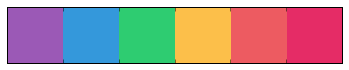

In [5]:
flatui = ["#9b59b6", "#3498db", "#2ecc71","#fcbf4a", "#ed5b61", "#e52c66"]
sns.palplot(sns.color_palette(flatui))

In [196]:
#project a onto b
def vector_reject(a,b): #a gives variance to be
    return a - (np.dot(a,b)/np.dot(b,b)) * b   
set(all_rsas['mask'])

{'V1_V2', 'hipp', 'para_sim', 'peri_sim'}

# Load and visualize RSA data

In [198]:
#load RSAs from disk
all_rsas = []
for sub in subs:
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim_ifs.pkl')
    rsa = pd.read_pickle(out_f)
    all_rsas.append(rsa)
all_rsas = pd.concat(all_rsas)

In [199]:
fig_rsas = pd.read_csv('/home/iballard/Dropbox/fd/rsa.csv')
fig_rsas = fig_rsas.set_index(['mask','run','sub'])

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  import sys
/home/iballard/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


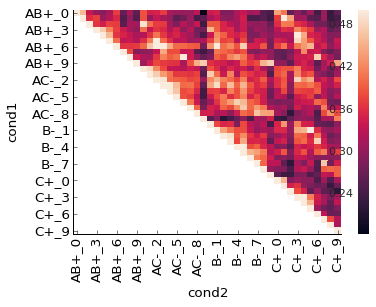

In [9]:
roi = 'V1_V2'
run = 2
plt.title('')
sns.set_context('paper',font_scale = 1.4,rc={"figure.figsize": (20, 20)})
sns.set_style("white")

mean_rsa = fig_rsas.loc[roi,run].groupby(['cond1','cond2']).mean().sort_index()
mean_rsa = mean_rsa.unstack()['corr']
sns.heatmap(mean_rsa, vmax = .5)
sns.despine()

plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/' + roi + '.svg',dpi = 600)

# Load results of RL modeling

In [11]:
RL_next = pd.read_csv('/home/iballard/fdPE_V_nexttrial.csv')
RL_next = RL_next[RL_next['condition'] != 'feedback']
RL_next = RL_next.set_index(['exp','sub','run','condition'])
RL_next = RL_next.loc[('sim','fd_104')]

RL_std = pd.read_csv('/home/iballard/fdPE_V_trial.csv')
RL_std = RL_std[RL_std['condition'] != 'feedback']
RL_std = RL_std.set_index(['exp','sub','run','condition'])
RL_std = RL_std.loc[('sim','fd_104')]

for i in range(1,4):
    RL_std.loc[i,'trial'] = range(0,40)
RL_std.loc[(2,'c_plus')]

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  del sys.path[0]


PE  duration  feedback_valence    onset  rew     rt  \
run condition                                                              
2   c_plus    -1.000000         0               NaN   17.013  0.0    NaN   
    c_plus    -0.600000         0               NaN   34.034  0.0    NaN   
    c_plus     1.640000         0               NaN   43.041  1.0    NaN   
    c_plus     0.984000         0               NaN  117.322  1.0    NaN   
    c_plus     0.590400         0               NaN  143.957  1.0  556.0   
    c_plus     0.354240         0               NaN  158.970  1.0  452.0   
    c_plus     0.212544         0               NaN  238.049  1.0  690.0   
    c_plus     0.127526         0               NaN  302.728  1.0  578.0   
    c_plus     0.076516         0               NaN  319.748  1.0  600.0   
    c_plus    -1.954090         0               NaN  358.796  0.0    NaN   

                      V  trial  
run condition                   
2   c_plus     0.000000    1.0  
    c_plus    -0.400000    3.0  
    c_plus    -0.640000    4.0  
    c_plus     0.016000   11.0  
    c_plus     0.409600   14.0  
    c_plus     0.645760   15.0  
    c_plus     0.787456   24.0  
    c_plus     0.872474   31.0  
    c_plus     0.923484   33.0  
    c_plus     0.954090   38.0

# Conduct RSA Analysis

In [219]:
def get_base_model(sub,mask): 
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    overlap_pairs = [['b_plus','b_minus'],
                    ['c_plus','c_minus'],
                    ['b_plus','c_minus']]
    overlap_pairs = [set(x) for x in overlap_pairs] #so order doesnt matter
    not_overlap_pairs = [['c_plus','b_minus'],
                         ['b_plus','c_plus'],
                      ['c_minus','b_minus']]
    not_overlap_pairs = [set(x) for x in not_overlap_pairs] #so order doesnt matter


    singles = [['c_plus','c_plus'],['b_minus','c_plus'], ['b_minus','b_minus']]
    singles = [set(x) for x in singles] #so order doesnt matter
    doubles = [['b_plus','b_plus'], ['b_plus','c_minus'],['c_minus','c_minus']]     
    doubles = [set(x) for x in doubles] #so order doesnt matter
                
    #get dataframe
    sub_rsa = all_rsas.set_index(['mask','sub','run']).sort_index()
    sub_rsa = sub_rsa.loc[(mask,sub)]
    runs = set(sub_rsa.index)

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'identity' : [],
    'time' : [],
    'overlap' : [],
    'value_std' : [],
    'value_next' : [],
    'nstim':[],
    'pe':[],
    'run' : [], 
    'corr' : [],
    'cond1':[],
    'cond2':[]}
    

    for run in runs:
        for c1, c2, r in zip(sub_rsa.loc[run,'cond1'].values,
                             sub_rsa.loc[run,'cond2'].values,
                             sub_rsa.loc[run,'corr'].values):

            #get variables in tidy format
            cond1, trial1 = c1.split('_')
            cond2, trial2 = c2.split('_')
            cond1 = reverse_name_map[cond1]
            cond2 = reverse_name_map[cond2]

            #get reward codings
            r1 = RL_std.loc[(run,cond1),'rew'].values[trial1]
            r2 = RL_std.loc[(run,cond2),'rew'].values[trial2]
            same = int(r1 == r2)
            val = int(same)
            if r1 < 1.0:
                val = 0
            model['response'].append(same)
            model['valence'].append(val)

            ##identity
            iden= int(cond1 == cond2)
            model['identity'].append(iden)

            #trial diff (in real time)
            t1 = RL_std.loc[(run,cond1),'trial'].values[trial1]
            t2 = RL_std.loc[(run,cond2),'trial'].values[trial2]
            tdiff = abs(t1 - t2)
            model['time'].append(tdiff) 
            
            #number of stimuli
            if set([cond1,cond2]) in singles:
               nstim = -1
            elif set([cond1,cond2]) in doubles:
               nstim = 1
            else:
               nstim = 0
            model['nstim'].append(nstim)
               
            #overlap
            ov = set([cond1,cond2]) in overlap_pairs
            non_ov = set([cond1,cond2]) in not_overlap_pairs
            model['overlap'].append(int(ov) - int(non_ov))

            #value difference
            v1 = RL_std.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'V'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['value_std'].append(vdiff)
            
            #value difference
            v1 = RL_next.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_next.loc[(run,cond2),'V'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['value_next'].append(vdiff)

            #PE difference
            v1 = RL_std.loc[(run,cond1),'PE'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'PE'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['pe'].append(vdiff)
  
            #run
            model['run'].append(run)

            #corr
            model['corr'].append(r)

            #cond labels
            model['cond1'].append(c1)
            model['cond2'].append(c2)

    model = pd.DataFrame(model)
    return model

In [220]:
#build Data frame for modeling
base = get_base_model('fd_104','hipp')
mask_models={}
for mask in masks:
    all_models = {}

    for sub in subs:
        sub_rsa = all_rsas.set_index(['mask','sub','run'])
        sub_rsa = sub_rsa.loc[(mask,sub)]
        runs = sorted(set(sub_rsa.index))
        
        #deal with uneven number of runs
        base_runs = [1,2,3]
        sub_df = base.copy()
        if len(runs) != len(base_runs): #right number of runs
            bad_runs = set(runs) ^ set(base_runs)
            for bad_run in bad_runs:
                sub_df = sub_df[sub_df['run'] != bad_run]
        all_models[sub] = sub_df

        corr = []
        for run in runs:
            r = sub_rsa.loc[run]['corr'].values
            corr.extend(r)
            
        all_models[sub]['corr'] = corr

    mask_models[mask] = dict(all_models)

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/si

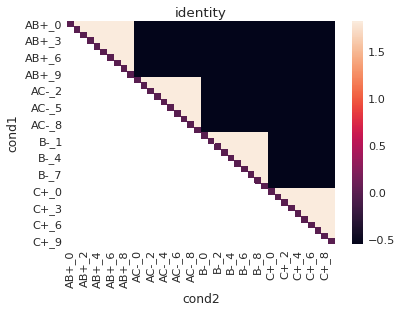

In [186]:
#Visualize regressors for the model of the RSA matrix
tmp  = mask_models['hipp']['fd_104'].copy()
tmp = tmp[tmp['run'] ==3]


x_var = 'identity'
tmp[x_var] = scipy.stats.zscore(tmp[x_var])
# tmp[x_var] = vector_reject(tmp[x_var].values, tmp['valence'].values)

sns.set_context('paper',font_scale = 1.4,rc={"figure.figsize": (20, 20)})
sns.set_style("white")


tmp = tmp[['cond1','cond2',x_var]]
new_df = pd.DataFrame()
for cond in ['AB+_','B-_','AC-_','C+_']:
    for i in range(10):
        row = pd.DataFrame({x_var:0,
                            'cond1':cond + str(i),
                            'cond2':cond + str(i)},index = [0])
        new_df = new_df.append(row)
tmp = pd.concat([tmp,new_df])
tmp = tmp.groupby(['cond1','cond2']).mean().unstack()[x_var]
sns.heatmap(tmp)
plt.title(x_var)
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/model_' + x_var +'.svg',dpi = 600)

# Deal with screen order

In [254]:
screen_order = pd.read_csv(op.join('/home','iballard','Dropbox','fd','sim_screen_order.csv'))
screen_order = screen_order.set_index(['sub','run','cond'])
for row in set(screen_order.index):
    screen_order.loc[row,'cond_num'] = map(int,np.arange(10))
screen_order = screen_order.reset_index()
screen_order['condition'] = [name_map[x] + str(int(c)) for x,c in zip(screen_order['cond'].values,
                                                                       screen_order['cond_num'].values)]
screen_order = screen_order.set_index(['sub','run']).sort_index()

In [289]:
screen_rsa.loc['fd_107'].set_index(['run','cond1','cond2']).loc[(3,'B-_0')]

,different_hemi
cond2,
AB+_0,True
AB+_1,True
AB+_2,False
AB+_3,True
AB+_4,False
AB+_5,True
AB+_6,False
AB+_7,True
AB+_8,True


In [288]:
screen_order.loc[('fd_107',3)]

cond  lr  trial  cond_num condition
sub    run                                        
fd_107 3    b_minus   0      2       0.0      B-_0
       3    b_minus   1      6       1.0      B-_1
       3    b_minus   1      7       2.0      B-_2
       3    b_minus   1     15       3.0      B-_3
       3    b_minus   0     20       4.0      B-_4
       3    b_minus   0     28       5.0      B-_5
       3    b_minus   1     29       6.0      B-_6
       3    b_minus   0     32       7.0      B-_7
       3    b_minus   0     35       8.0      B-_8
       3    b_minus   0     37       9.0      B-_9
       3     b_plus   0      1       0.0     AB+_0
       3     b_plus   0      4       1.0     AB+_1
       3     b_plus   1      8       2.0     AB+_2
       3     b_plus   0     12       3.0     AB+_3
       3     b_plus   1     14       4.0     AB+_4
       3     b_plus   0     16       5.0     AB+_5
       3     b_plus   1     24       6.0     AB+_6
       3     b_plus   0     34       7.0     AB+_7
       3     b_plus   0     36       8.0     AB+_8
       3     b_plus   0     38       9.0     AB+_9
       3    c_minus   0     13       0.0     AC-_0
       3    c_minus   1     17       1.0     AC-_1
       3    c_minus   0     18       2.0     AC-_2
       3    c_minus   1     19       3.0     AC-_3
       3    c_minus   1     21       4.0     AC-_4
       3    c_minus   1     23       5.0     AC-_5
       3    c_minus   1     26       6.0     AC-_6
       3    c_minus   0     31       7.0     AC-_7
       3    c_minus   0     33       8.0     AC-_8
       3    c_minus   0     40       9.0     AC-_9
       3     c_plus   0      3       0.0      C+_0
       3     c_plus   1      5       1.0      C+_1
       3     c_plus   0      9       2.0      C+_2
       3     c_plus   1     10       3.0      C+_3
       3     c_plus   1     11       4.0      C+_4
       3     c_plus   1     22       5.0      C+_5
       3     c_plus   1     25       6.0      C+_6
       3     c_plus   1     27       7.0      C+_7
       3     c_plus   1     30       8.0      C+_8
       3     c_plus   0     39       9.0      C+_9

In [163]:
screen_rsa = {'cond1':[],'cond2':[],'different_hemi':[],'run':[],'sub':[]}

for row in set(screen_order.index):
    
    sub,run = row
    sub_df = screen_order.loc[row].set_index('condition').sort_index()
    
    for trial1 in set(sub_df.index):
        for trial2 in set(sub_df.index):
            
            cond1 = sub_df.loc[trial1,'cond']
            cond2 = sub_df.loc[trial2,'cond']
            lr1 = sub_df.loc[trial1,'lr']
            lr2 = sub_df.loc[trial2,'lr']
            cond_set = set([cond1,cond2]) #useful so order doesnt matter
            
            diff = False
            if cond1 == cond2 and lr1 != lr2:
                diff = True
            if cond_set in [set(['b_plus','c_minus'])] and lr1 != lr2:
                diff = True
            if cond_set in [set(['b_plus','c_plus']),set(['c_minus','b_minus']),set(['b_minus','c_plus'])]:
                diff = True
            if cond_set in [set(['b_plus','b_minus']),set(['c_minus','c_plus'])] and lr1 == lr2:
                diff = True
            
            screen_rsa['different_hemi'].append(diff)
            screen_rsa['sub'].append(sub)
            screen_rsa['run'].append(run)
            screen_rsa['cond1'].append(trial1)
            screen_rsa['cond2'].append(trial2)
screen_rsa = pd.DataFrame(screen_rsa)
screen_rsa.to_csv(home_dir + '/screen_order.csv',index = False)
screen_rsa = screen_rsa.sort_values(by = ['sub','run','cond1','cond2']).set_index('sub')

In [201]:
screen_rsa = pd.read_csv(home_dir + '/screen_order.csv')
screen_rsa = screen_rsa.sort_values(by = ['sub','run','cond1','cond2']).set_index('sub')

# Run linear model

In [223]:
print masks

['V1_V2', 'yeo17_ifs', 'hipp', 'peri_sim', 'para_sim']


In [280]:
value_regressors = ['value_next','value_std','pe']
regressors = ['response','valence','identity','overlap','pe','value_next','time','time2','run','different_hemi']

model = []
for mask_idx,mask in enumerate(masks):
    #deal with time
    for n,sub in enumerate(subs):
        m = mask_models[mask][sub].copy()
        
        #add in info about screen location
        m = pd.merge(screen_rsa.loc[sub],
         m,
         how = 'inner')
#         m = m[m['different_hemi'] == False] #subsample to only look at different hemispheres
        
        m['time'] = scipy.stats.zscore(m['time'])
        m['time2'] = [x**2 for x in m['time']]
        
        #standardize regressors
        for r in regressors:
            if r not in ['run','different_hemi']: #categorical
                m[r] = scipy.stats.zscore(m[r])
        
        #subjects
        m['sub'] = n
        m['mask'] = mask
        
        #clean up dataframe
        all_cols = list(regressors)
        all_cols.extend(['corr','sub','mask'])
        m = m[all_cols]

        #orthogonalize
        for v_regress in value_regressors:
            if v_regress in regressors:
                m[v_regress] = vector_reject(m[v_regress],m['response'])
                m[v_regress] = vector_reject(m[v_regress],m['valence'])

        #process y
        m['corr'] = map(np.arctanh,m['corr'])
        model.append(m.copy())
        
model = pd.concat(model)
model['roi'] = [roi_names[x] for x in model['mask']]

#set up model
model_str = ['corr ~ 1']
for r in regressors:
    model_str.append(r)
model_str = '+'.join(model_str)
print model_str

corr ~ 1+response+valence+identity+overlap+pe+value_next+time+time2+run+different_hemi


In [187]:
v1 = model.set_index('mask').loc['hipp']
v1 = v1[v1['identity'] > 0]
v1 = v1.groupby(['different_hemi','sub']).mean()['corr']
print scipy.stats.ttest_1samp(v1[False] - v1[True],0)
np.mean(v1[False]),np.mean(v1[True])

Ttest_1sampResult(statistic=1.0917090274947807, pvalue=0.28337340223035612)


(0.5045728829815704, 0.5023071831695545)

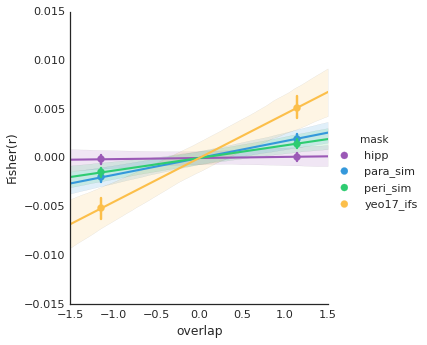

In [206]:
#project out nuisance variables
m = model.copy()
# m = m[m['different_hemi'] == True]
m = m.reset_index().set_index(['mask','sub']).sort_index()
for row in set(m.index):
    
    df = m.loc[row]
    
    model_str = 'corr ~ 1 + response + valence + time + time2 + identity + pe + value_next + C(run,Sum)'
    fit = ols(model_str,df).fit()
    m.loc[row,'resid'] = fit.resid.values

m = m.reset_index()
overlap = m[m['overlap'] != 0]

sns.lmplot(y = 'resid',x= 'overlap',
           x_bins =2,
           x_ci = 68,
           palette = flatui,
           hue = 'mask', data = overlap)
plt.ylabel('Fisher(r)')
plt.savefig('/home/iballard/Dropbox/fd/figs/paper/data_overlap.png', 
            dpi = 300,
           bbox_inches = 'tight')

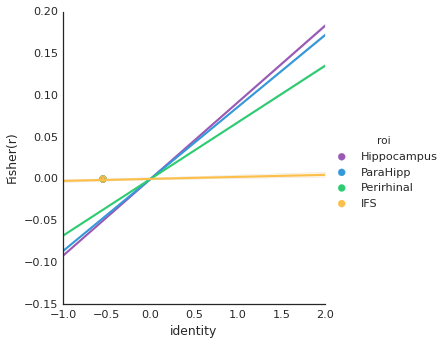

In [207]:
#project out nuisance variables
m = model.copy()
# m = m[m['different_hemi'] == True]
m = m.reset_index().set_index(['mask','sub']).sort_index()
for row in set(m.index):
    
    df = m.loc[row]
    
    model_str = 'corr ~ 1 + response + valence + time + time2 + overlap + pe + value_next + C(run,Sum)'
    fit = ols(model_str,df).fit()
    m.loc[row,'resid'] = fit.resid.values

m = m.reset_index()

sns.lmplot(y = 'resid',x= 'identity', 
           x_bins = 2,
           x_jitter = .3,
           palette = flatui,
           hue = 'roi', data = m)
plt.ylabel('Fisher(r)')

plt.savefig('/home/iballard/Dropbox/fd/figs/paper/data_identity.png', 
            dpi = 300,
           bbox_inches = 'tight')

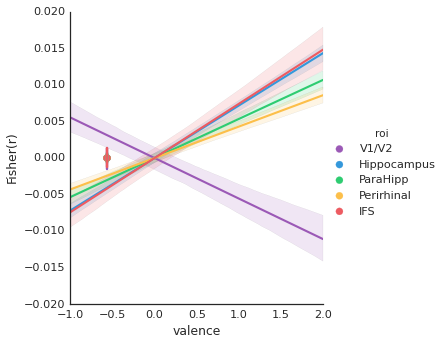

In [290]:
#project out nuisance variables
m = model.copy()
# m = m[m['different_hemi'] == True]
m = m.reset_index().set_index(['mask','sub']).sort_index()
for row in set(m.index):
    
    df = m.loc[row]
    
    model_str = 'corr ~ 1 + identity + time + time2 + overlap + pe + C(run,Sum)'
    fit = ols(model_str,df).fit()
    m.loc[row,'resid'] = fit.resid.values

m = m.reset_index()

sns.lmplot(y = 'resid',x= 'valence', 
           x_bins = 2,
           x_jitter = .3,
           palette = flatui,
           hue = 'roi', data = m)
plt.ylabel('Fisher(r)')

plt.savefig('/home/iballard/Dropbox/fd/figs/paper/data_target.png', 
            dpi = 300,
           bbox_inches = 'tight')

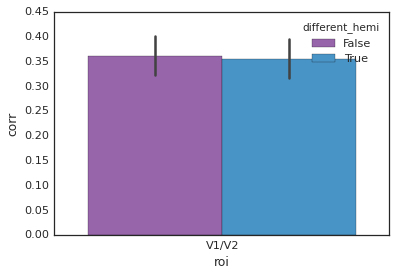

In [276]:
m = model#[model['identity'] > 0]
m = m.groupby(['roi','different_hemi','sub']).mean().reset_index()

sns.barplot(x = 'roi',y = 'corr', hue = 'different_hemi', data = m, palette = flatui)

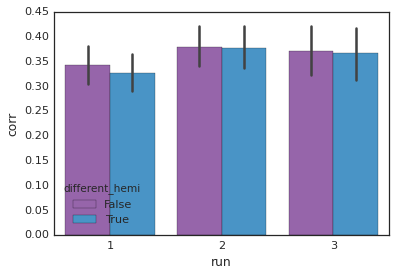

In [281]:
m = model[model['identity'] > 0]
m = model[model['roi'] == 'V1/V2']

m = m.groupby(['roi','different_hemi','sub','run']).mean().reset_index()

sns.barplot(x = 'run',y = 'corr', hue = 'different_hemi', data = m, palette = flatui)

# Run Permutation Test

In [52]:
model = model.set_index(['mask','sub'])

In [434]:
def permute_data(permuation_number):
    shuffled_params = pd.DataFrame()
    
    #loop through masks and subjects
    for row in set(model.index):
        df = model.loc[row].copy()

        #shuffle
        df['corr'] = np.random.permutation(df['corr'])

        #fit model
        model_str = 'corr ~ 1 + response + valence + time + time2 + pe + value_next + overlap + identity'
        fit = ols(model_str,df).fit()

        #compile results
        new_data = fit.params
        new_data['sub'] = str(row[1])
        new_data['mask'] = row[0]
        shuffled_params = shuffled_params.append(new_data, ignore_index = True)
    
    #save data
    out_f = op.join(op.abspath('../permutation'),'shuffled_' + str(permuation_number) + '.csv')
    shuffled_params.to_csv(out_f,index = False)

In [55]:
# dview = rc[0:52]
# dview.block = True

# dview.push(dict(home_dir=home_dir,
#                 model = model,
#                   ))
# dview.execute("import numpy as np")
# dview.execute("import os.path as op")
# dview.execute("import pandas as pd")
# with dview.sync_imports():
#     import os
#     import numpy
#     import scipy
#     import scipy.stats
#     from statsmodels.formula.api import ols
n_permutations = 1000
# dview.map_sync(permute_data,np.arange(n_permutations))

# Get means for each regressor

In [122]:
# loop through masks and subjects
model = model.set_index(['mask','sub']).sort_index()
fit_params = pd.DataFrame()
for row in set(model.index):
    df = model.loc[row].copy()

    #fit model
    model_str = 'corr ~ 1 + response + valence + time + pe + value_next + overlap + identity + C(run,Sum)'
    fit = ols(model_str,df).fit()

    #compile resprint ults
    new_data = fit.params
    new_data['sub'] = str(row[1])
    new_data['mask'] = row[0]
#     new_data['run'] = row[2]
    fit_params = fit_params.append(new_data, ignore_index = True)
fit_params = fit_params.groupby('mask').mean().reset_index()

In [57]:
#load data
shuffled_params = []
for permuation_number in range(n_permutations):
    out_f = op.join(op.abspath('../fd/permutation'),'shuffled_' + str(permuation_number) + '.csv')
    df = pd.read_csv(out_f)
    df['sample'] = permuation_number
    shuffled_params.append(df)
shuffled_params = pd.concat(shuffled_params)
shuffled_params = shuffled_params.groupby(['mask','sample']).mean().reset_index()

In [58]:
shuffled_params['roi'] = [roi_names[x] for x in shuffled_params['mask']]
fit_params['roi'] = [roi_names[x] for x in fit_params['mask']]

In [59]:
def get_p_value(shuffled_params,fit_params,regressor, side):
    p_values = {}
    for m in masks:
        shuff = shuffled_params.set_index('mask').loc[m,regressor]

        val = fit_params.set_index('mask').loc[m,regressor]

        if side == '>':
            p_values[m] = sum(shuff > val)/float(len(shuff))
        elif side == '<':
            p_values[m] = sum(shuff < val)/float(len(shuff))
    return pd.DataFrame(p_values,index = ['p'])

,V1_V2,hipp,para_sim,peri_sim
p,0.0,0.0,0.0,0.0


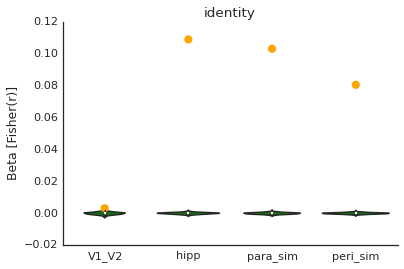

In [124]:
regressor = 'identity'
ax = sns.violinplot(x = 'mask',y= regressor,
               data = shuffled_params, 
               color = 'green')
sns.pointplot(x = 'mask',y = regressor,
              data = fit_params,
              color = 'orange',
              join = False, ax = ax)
sns.despine()
plt.ylabel('Beta [Fisher(r)]')
plt.xlabel('')
plt.title(regressor)
plt.savefig('/home/iballard/Dropbox/fd/figs/paper/permutation_' + regressor +'.png', 
            dpi = 300,
           bbox_inches = 'tight')
get_p_value(shuffled_params,fit_params,regressor,'>')

In [523]:
regressor = 'overlap'
other_mask = 'peri_sim'
diff = fit_params_mean.set_index('mask').loc['hipp',regressor] -  fit_params_mean.set_index('mask').loc[other_mask,regressor]
shuffled_differences = shuffled_params_mean.set_index('mask').loc['hipp',regressor].values - shuffled_params_mean.set_index('mask').loc[other_mask,regressor].values
sum(diff > shuffled_differences)/1000.0

0.016